In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
raw_data_path=os.path.join('data','raw')
df=pd.read_csv(os.path.join(raw_data_path,'fer2013.csv'))
X=[]
for i in range(len(df)):
    X.append(df.loc[i,'pixels'].split(' '))
X=np.array(X,np.float32)/255.
y=df.emotion.values
X_train=X[np.where(df.Usage=='Training')]
y_train=y[np.where((df.Usage=='Training'))]
X_test=X[np.where((df.Usage!='Training'))]
y_test=y[np.where((df.Usage!='Training'))]
def balance_classes(X,y):
    X1=X[np.where(y!=1)]
    X2=X[np.where(y==1)]
    X2=np.repeat(X2,9,axis=0)
    X=np.concatenate((X1,X2),axis=0)
    y1=y[np.where(y!=1)]
    y2=y[np.where(y==1)]
    y2=np.repeat(y2,9,axis=0)
    y=np.concatenate((y1,y2),axis=0)
    i=[i for i in range(len(y))]
    np.random.shuffle(i)
    return X[i],y[i]
X_train,y_train=balance_classes(X_train,y_train)
def one_hot_encoder(X):
    N=len(X)
    K=len(set(X))
    Z=np.zeros((N,K))
    for i in range(N):
        c=X[i]
        Z[i,c]=1
    return Z

In [2]:
import torch as t

In [3]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6}

In [4]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

In [5]:
len(X_test)

7178

In [15]:
class LeNet(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=t.nn.Conv2d(1,20,5,1)
        self.conv2=t.nn.Conv2d(20,50,5,1)   
        self.fc1=t.nn.Linear(9*9*50,500)
        self.fc2=t.nn.Linear(500,7)
        self.dropout1 = t.nn.Dropout(0.5)
    def forward(self,x):
        x=t.nn.functional.leaky_relu(self.conv1(x))
        x=t.nn.functional.max_pool2d(x,2,2)
        x=t.nn.functional.relu(self.conv2(x))
        x=t.nn.functional.max_pool2d(x,2,2)
        x=x.view(-1,9*9*50)
        x=t.nn.functional.relu(self.fc1(x))
        x=self.dropout1(x)
        x=self.fc2(x)
        return x
    

In [16]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=4050, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=7, bias=True)
  (dropout1): Dropout(p=0.5)
)

In [17]:
criterion = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr = 0.001)

In [18]:
inputs=X_train.reshape(32197,1,48,48)
labels=y_train

In [19]:
val_inputs_X=X_test.reshape(7178,1,48,48)
val_labels_y=y_test

In [20]:
inputs[1].shape


(1, 48, 48)

In [21]:
n_batches=320
batch_sz=100

In [22]:
epochs = 50
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for j in range(n_batches):
        Xbatch = inputs[j*batch_sz:(j*batch_sz+batch_sz)]
        Ybatch = labels[j*batch_sz:(j*batch_sz+batch_sz)]
        inputs_b = t.tensor(Xbatch).to(device)
        labels_b = t.tensor(Ybatch).to(device)
        outputs = model(inputs_b)
        loss = criterion(outputs, labels_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = t.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += t.sum(preds == labels_b.data)
    with t.no_grad():
        val_inputs = t.tensor(val_inputs_X).to(device)
        val_labels = t.tensor(val_labels_y).to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        _, val_preds = t.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += t.sum(val_preds == val_labels.data)
    epoch_loss = running_loss/len(inputs)
    epoch_acc = running_corrects.float()/ len(inputs)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    val_epoch_loss = val_running_loss/len(val_inputs)
    val_epoch_acc = val_running_corrects.float()/ len(val_inputs)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0177, acc 0.2944 
validation loss: 0.0002, validation acc 0.3941 
epoch : 2
training loss: 0.0150, acc 0.4255 
validation loss: 0.0002, validation acc 0.4296 
epoch : 3
training loss: 0.0134, acc 0.4873 
validation loss: 0.0002, validation acc 0.4629 
epoch : 4
training loss: 0.0124, acc 0.5282 
validation loss: 0.0002, validation acc 0.4682 
epoch : 5
training loss: 0.0116, acc 0.5564 
validation loss: 0.0002, validation acc 0.4773 
epoch : 6
training loss: 0.0110, acc 0.5746 
validation loss: 0.0002, validation acc 0.4845 
epoch : 7
training loss: 0.0106, acc 0.5931 
validation loss: 0.0002, validation acc 0.4794 
epoch : 8
training loss: 0.0102, acc 0.6120 
validation loss: 0.0002, validation acc 0.4865 
epoch : 9
training loss: 0.0098, acc 0.6221 
validation loss: 0.0002, validation acc 0.4911 
epoch : 10
training loss: 0.0094, acc 0.6391 
validation loss: 0.0002, validation acc 0.4951 
epoch : 11
training loss: 0.0091, acc 0.6505 
validation loss: 0.0002

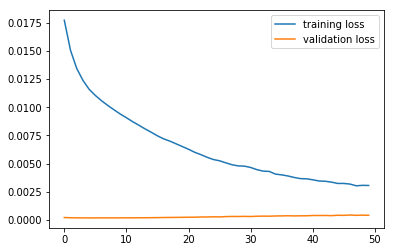

In [23]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

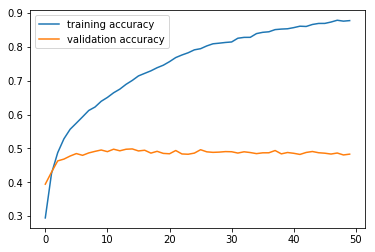

In [24]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()